In [1]:
from pathlib import Path
import warnings
import sys
import matplotlib.pyplot as plt

home_path = str(Path.cwd().parent)
sys.path.append(home_path)

sys.path.append('/eos/user/m/morwat/.local/lib/python3.9/site-packages/')

In [2]:
from aper_package.interactive_tool import InteractiveTool

In [3]:
warnings.filterwarnings('ignore')

tool = InteractiveTool()
tool.show()

(19500.0, 20500.0)

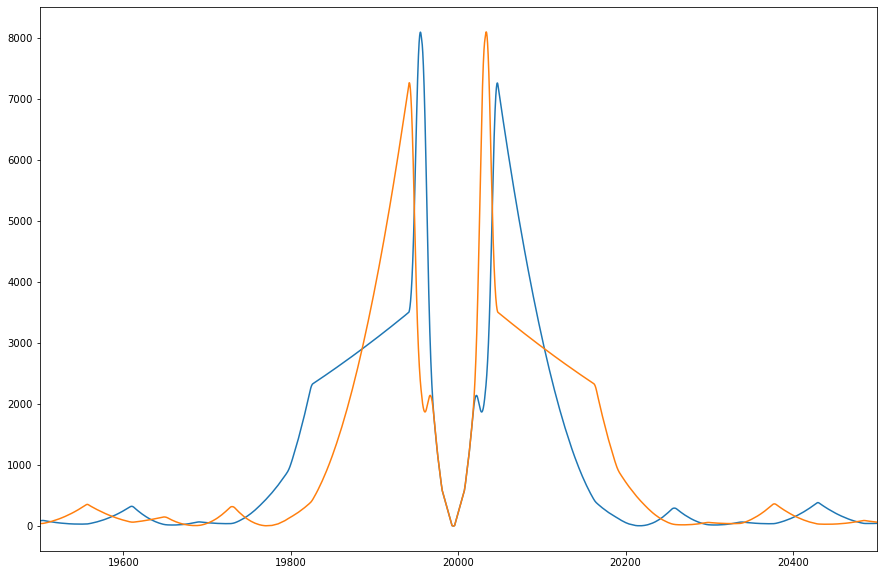

In [16]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(15,10))
ax.plot(tool.aperture_data.tw_b1.s, tool.aperture_data.tw_b1.betx)
ax.plot(tool.aperture_data.tw_b1.s, tool.aperture_data.tw_b1.bety)

ax.set_xlim(19500,20500)

In [14]:
import plotly.graph_objects as go
import numpy as np

# Create example traces to mimic the legend
s = np.linspace(0, 100, 500)
y_upper = np.sin(s / 10) + 0.5
y_lower = np.sin(s / 10) - 0.5
y_beam1 = np.sin(s / 10)
y_beam2 = np.cos(s / 15)
y_nominal1 = np.sin(s / 10) + 0.1
y_nominal2 = np.cos(s / 15) - 0.1

# Upper envelope Beam 1
trace_upper_b1 = go.Scatter(
    x=s,
    y=y_upper,
    mode='lines',
    name='Envelope',
    line=dict(color='rgba(0, 0, 255, 0.1)'),
    fill='tonexty',
    fillcolor='rgba(0,0,255,0.1)'
)


# Beam 1 position
trace_beam1 = go.Scatter(
    x=s,
    y=y_beam1,
    mode='lines',
    name='Beam 1',
    line=dict(color='blue')
)


# Nominal Beam 1
trace_nominal_b1 = go.Scatter(
    x=s,
    y=y_nominal1,
    mode='lines',
    name='Nominal beam 1',
    line=dict(color='blue', dash='dash')
)


# Apertures
trace_aperture_top = go.Scatter(
    x=s,
    y=np.full_like(s, 1.0),
    mode='lines',
    name='Aperture',
    line=dict(color='gray')
)


# BPM Data for Beam 1
bpm_data_b1 = go.Scatter(
    x=np.linspace(0, 100, 50),
    y=np.sin(np.linspace(0, 100, 50) / 10),
    mode='markers',
    name='BPM data Beam 1',
    marker=dict(color='blue', symbol='circle')
)

# Create figure
fig = go.Figure()

# Add traces
traces = [
    trace_upper_b1,
    trace_beam1, trace_nominal_b1,
    trace_aperture_top,bpm_data_b1
]

for trace in traces:
    fig.add_trace(trace)

# Update layout
fig.update_layout(
    title="Beam and Aperture Visualization (Legend Example)",
    xaxis_title="s [m]",
    yaxis_title="Position [m]",
    legend_title="Traces",
    template="plotly_white",
)

# Show the figure
fig.show()


In [1]:
import pandas as pd
import numpy as np
import tfs
df_no_nans = tool.aperture_data.aper_b1.dropna()
df_b1 = tfs.read('/eos/project-i02/c/collimation-team/machine_configurations/LHC_run3/2023/MADX/injection/aperture/ap_ir5b1.tfs')
df_b1['NAME']=df_b1['NAME'].str.lower()
df_no_nans['NAME']=df_no_nans['NAME'].str.lower()

NameError: name 'tool' is not defined

In [ ]:
survB1 = pd.read_csv('/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/MADX/injection/survey_b1.tfs', skiprows=8, header=None, sep='\s+', 
                     names=['NAME','KEYWORD','S','L','ANGLE','X','Y','Z','THETA','PHI','PSI','GLOBALTILT','TILT','SLOT_ID','ASSEMBLY_ID','MECH_SEP','V_POS','COMMENTS'])
survB2 = pd.read_csv('/eos/project-c/collimation-team/machine_configurations/LHC_run3/2023/MADX/injection/survey_b2.tfs', skiprows=8, header=None, sep='\s+', 
                     names=['NAME','KEYWORD','S','L','ANGLE','X','Y','Z','THETA','PHI','PSI','GLOBALTILT','TILT','SLOT_ID','ASSEMBLY_ID','MECH_SEP','V_POS','COMMENTS'])

In [ ]:
merged = pd.merge(df_no_nans, df_b1, on='NAME')
merged['N1x_calculated'] = (merged['APER_1_x']-merged['RTOL']-merged['XTOL']-0.002-merged['X'])/(np.sqrt(1.15*merged['BETX']*tool.aperture_data.epsilon+(merged['DX']**2)*(0.00031**2)))
merged['N1y_calculated'] = (merged['APER_2_x']-merged['RTOL']-merged['YTOL']-0.002-merged['Y'])/(np.sqrt(1.15*merged['BETY']*tool.aperture_data.epsilon+(merged['DY']**2)*(0.00031**2)))

merged2 = pd.merge(df_no_nans, df_b1, on='NAME')
merged2['N1x_calculated'] = (merged['APER_1_x']-merged['RTOL']-merged['XTOL']-0.002-merged['X']+merged['MECH_SEP'])/(np.sqrt(1.15*merged['BETX']*tool.aperture_data.epsilon+(merged['DX']**2)*(0.00031**2)))
merged2['N1y_calculated'] = (merged['APER_2_x']-merged['RTOL']-merged['YTOL']-0.002-merged['Y'])/(np.sqrt(1.15*merged['BETY']*tool.aperture_data.epsilon+(merged['DY']**2)*(0.00031**2)))



In [ ]:
merged[['NAME', 'N1', 'N1x_calculated', 'N1y_calculated']].NAME.values[-1]

In [ ]:
ip5pos = 13329.289216000001

fig,ax = plt.subplots(figsize=(20,15))
ax.plot(merged.S_x-ip5pos,merged.N1)
ax.plot(merged.S_x-ip5pos,np.min(np.array([merged.N1x_calculated.values,merged.N1y_calculated.values]),axis=0))
#ax.plot(merged2.S_x-ip5pos,np.min(np.array([merged2.N1x_calculated.values,merged2.N1y_calculated.values]),axis=0))
ax.set_ylim(0,50)
fig.show()

In [ ]:
merged[merged.NAME.str.contains('mqxa')]

In [ ]:
np.sum(merged['MECH_SEP'])

In [ ]:
merged.iloc[-1]

In [ ]:
def calcaper(ele,df,rtol=1,xtol=1,dp=0.00086,betabeat=1.15,parasitic=True,dpara=0.14,fdqf=2.086,betaarc=170.25):
    row = df[df.NAME==ele]
    dx0 = row['DX']
    dy0 = row['DY']
    if parasitic:
        dx = dx0*(np.sqrt(betabeat)-1) + (betabeat*np.sqrt(row['BETX'])*fdqf*dpara)/np.sqrt(betaarc)
        dy = dy0*(np.sqrt(betabeat)-1) + (betabeat*np.sqrt(row['BETY'])*fdqf*dpara)/np.sqrt(betaarc)
    else:
        dx, dy = dx0, dy0
    aperx = (row['APER_1_x']-rtol*row['RTOL']-xtol*row['XTOL']-0.002-np.abs(row['X']))/(np.sqrt(betabeat*row['BETX']*tool.aperture_data.epsilon+(dx*dp)**2))
    apery = (row['APER_2_x']-rtol*row['RTOL']-xtol*row['YTOL']-0.002-np.abs(row['Y']))/(np.sqrt(betabeat*row['BETY']*tool.aperture_data.epsilon+(dy*dp)**2))
    print([ele,aperx.values[0],apery.values[0],row['N1'].values[0],row['APER_1_x'].values[0],row['RTOL'].values[0],row['XTOL'].values[0],row['BETX'].values[0],row['DX'].values[0]])

In [ ]:
calcaper('mcbh.13r5.b1',merged)
calcaper('mcbh.13r5.b1',merged,rtol=0)
calcaper('mcbh.13r5.b1',merged,xtol=0)
calcaper('mcbh.13r5.b1',merged,dp=3.1e-4)
calcaper('mcbh.13r5.b1',merged,parasitic=True)

In [ ]:
calcaper('mcbh.13r5.b1',merged,betabeat=1.15)
calcaper('mcbh.13r5.b1',merged,betabeat=1.15,)

In [ ]:
tool.aperture_data.epsilon

In [ ]:
3.5e-6*0.938/450

In [ ]:
survB1[survB1.NAME=='mcbh.13r5.b1'.upper()]

In [ ]:
survB1[survB1.NAME=='ip5'.upper()]

In [ ]:
angle2 = -3.212992/2

angle2 = np.arctan2(-8399.576419,-546.205716)

rotMat=np.array([[np.cos(angle2),-np.sin(angle2)],[np.sin(angle2),np.cos(angle2)]])

xzrot = np.dot(rotMat,np.array([-8399.576419,-546.205716]))
print(xzrot)
xzrot[1] - 8409.452148

In [ ]:
angle2 = -3.141593
rotMat=np.array([[np.cos(angle2),-np.sin(angle2)],[np.sin(angle2),np.cos(angle2)]])

np.dot(rotMat,np.array([-8409.452134,0.000027]))

In [ ]:
def rotTrans(data,ref,refMechSep):
    angle=np.arctan2(ref[1],ref[0]+8409.452148/2)
    if((angle<-0.75) & (angle>-0.8)):
        adj=-0.00267
    else:
        adj=0
        
    angle2=-angle+np.pi/2+adj
    
    rotMat=np.array([[np.cos(angle2),-np.sin(angle2)],[np.sin(angle2),np.cos(angle2)]])
    
    temp1=data.copy()
    temp1['X']+=8409.452148/2
    adjust=np.dot(rotMat,np.array([ref[0]+8409.452148/2,ref[1]]))
    temp=np.empty((0,2))
    for index,row in temp1.iterrows():
        row2=np.dot(rotMat,row[['X','Z']])-np.array([adjust[0],adjust[1]-refMechSep])
        temp=np.append(temp,[row2],axis=0)
        
    temp1['X']=temp[:,0]
    temp1['Z']=temp[:,1]
    


    return(temp1)

In [ ]:
ipMechSep=[0,0,-0.224,-0.42,0,0.194,0.224,0]
ipPltRange=[0.22,0.26,0.20,0.34,0.22,0.22,0.22,0.26]
ip = 5
minRange=-400
maxRange=400

b1Orbit=rotTrans(tp.survGetDataRange(survB1,'b1',['IP'+str(ip),minRange],['IP'+str(ip),maxRange],['X','Z','NAME'],'IP'+str(ip),False),
                   tp.survGetDataRange(survB1,'b1',['IP'+str(ip),-25],['IP'+str(ip),+25],
                                    ['X','Z'],'IP'+str(ip),False).loc['IP'+str(ip)].values,
                 ipMechSep[ip-1]/2
                )